# Standard Imports

In [1]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, ConcatDataset, Subset
from collections import Counter
from torchvision import transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, balanced_accuracy_score, f1_score, roc_curve 

# Custom Imports

In [2]:
custom_modules_path = os.path.abspath(r'F:\Capstone\DFCA')

# Add the path to sys.path
if custom_modules_path not in sys.path:
    sys.path.append(custom_modules_path)

from utils.datasets import PairedSpectrogramDataset
from utils.augmentations import ZScoreNormalizeSpectrogram,AugmentSpectrogram
from utils.metrics_utils import calculate_pAUC, plot_confusion_matrix
from models.feature_extractor import CQTFeatureExtractor,STFTFrequencyAdaptiveFeatureExtractor
from models.heads import AnomalyScorer

f:\CapStone\DFCA\capstone\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# SimpleFusedModel

In [3]:
class SimpleFusedModel(nn.Module):
    def __init__(self, head):
        super().__init__()
        self.stft_net = STFTFrequencyAdaptiveFeatureExtractor()
        self.cqt_net = CQTFeatureExtractor()
        self.stft_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.cqt_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.head = head

    def forward(self, stft, cqt):
        stft_features = self.stft_net(stft)
        cqt_features = self.cqt_net(cqt)
        stft_vec = torch.flatten(self.stft_pool(stft_features), 1)
        cqt_vec = torch.flatten(self.cqt_pool(cqt_features), 1)
        fused_vec = torch.cat((stft_vec, cqt_vec), dim=1)
        return self.head(fused_vec)

# Device Configfuration's

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}" + (f" - {torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else ""))

FEATURES_DIR = os.path.abspath(r'F:\CapStone\DFCA\data\features\-6_dB_features')
CHECKPOINT_DIR = os.path.abspath(r'F:\Capstone\DFCA\checkpoints\Fused')
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
print(f"Checkpoints will be saved to: {CHECKPOINT_DIR}")


BATCH_SIZE = 32
NUM_EPOCHS = 50
LR = 5e-5
WEIGHT_DECAY = 1e-2
PATIENCE=5

print(f"Learning Rate: {LR} | Weight decay: {WEIGHT_DECAY}")

Using Device: cuda - NVIDIA GeForce MX450
Checkpoints will be saved to: F:\Capstone\DFCA\checkpoints\Fused
Learning Rate: 5e-05 | Weight decay: 0.01


# Evaluate and Training Loops

In [5]:
def _compute_primary_probs_and_loss_from_head(outputs, labels, criterion):
    """
    Computes probabilities, predictions, and loss for a binary classifier head.
    """
    logits = outputs.squeeze()
    probs = torch.sigmoid(logits)
    loss = criterion(logits, labels.float())
    preds = (probs > 0.5).long()
    return probs, preds, loss

def evaluate_model(model, data_loader, criterion, phase="Evaluation", device=device, threshold=0.5):
    model.eval()
    running_loss = 0.0
    all_labels, all_probs = [], []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc=phase):
            # 1. Load data to the specified device
            stft, cqt, labels= batch['stft'].to(device), batch['cqt'].to(device), batch['label'].to(device)
            outputs = model(stft, cqt)

            probs, _, loss = _compute_primary_probs_and_loss_from_head(outputs, labels, criterion)

            running_loss += loss.item() * stft.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.detach().cpu().numpy())

    # --- Metrics Calculation ---
    avg_loss = running_loss / len(data_loader.dataset)
    
    # During validation, find the best F1-score and its threshold
    best_threshold = threshold
    if phase == "Validation":
        best_f1 = 0
        for thresh in np.arange(0.01, 1.0, 0.01):
            preds_at_thresh = (np.array(all_probs) > thresh).astype(int)
            f1_candidate = f1_score(all_labels, preds_at_thresh)
            if f1_candidate > best_f1:
                best_f1 = f1_candidate
                best_threshold = thresh
        print(f"Optimal Threshold found: {best_threshold:.2f} (Best F1-score: {best_f1:.4f})")

    # Use the best threshold for final predictions
    all_preds = (np.array(all_probs) > best_threshold).astype(int)
    
    # Calculate all metrics
    auc_score = roc_auc_score(all_labels, all_probs) if len(np.unique(all_labels)) > 1 else float('nan')
    acc_score = accuracy_score(all_labels, all_preds)
    bacc_score = balanced_accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"{phase} -> Loss: {avg_loss:.4f} | AUC: {auc_score:.4f} | ACC: {acc_score:.4f} | BACC: {bacc_score:.4f} | F1: {f1:.4f}")
    print(f"Prediction Distribution: {dict(Counter(all_preds))}")

    return avg_loss, auc_score, acc_score, bacc_score, f1, all_labels, all_probs, best_threshold

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, model_save_path, device=device, save_plots=True, patience=5):
    best_val_auc = -np.inf
    best_val_loss = np.inf
    best_val_bacc = -np.inf
    best_threshold = 0.5
    patience_counter = 0

    train_losses, val_losses = [],[]
    train_accs, val_accs = [], []
    train_baccs, val_baccs = [], []
    train_aucs, val_aucs = [], []
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        all_labels, all_probs, all_preds = [], [], []

        for batch in tqdm(train_loader, desc="Train"):
            stft, cqt, labels = batch['stft'].to(device), batch['cqt'].to(device), batch['label'].to(device)
            
            optimizer.zero_grad()

            logits = model(stft, cqt)

            probs, preds, loss = _compute_primary_probs_and_loss_from_head(logits, labels, criterion)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * stft.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.detach().cpu().numpy())
            all_preds.extend(preds.detach().cpu().numpy())

        # --- End of Epoch: Calculate Training Metrics ---
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_auc = roc_auc_score(all_labels, all_probs)
        epoch_acc = accuracy_score(all_labels, all_preds)
        epoch_bacc = balanced_accuracy_score(all_labels, all_preds)

        train_losses.append(epoch_loss)
        train_aucs.append(epoch_auc)
        train_accs.append(epoch_acc)
        train_baccs.append(epoch_bacc)
        
        print(f"Train -> Loss: {epoch_loss:.4f} | AUC: {epoch_auc:.4f} | ACC: {epoch_acc:.4f} | BACC: {epoch_bacc:.4f}")

        # --- Validation Step ---
        val_loss, val_auc, val_acc, val_bacc, _, _, _, current_optimal_threshold = evaluate_model(
            model, val_loader, criterion, phase="Validation", device=device, threshold=best_threshold # type: ignore
        )

        val_losses.append(val_loss)
        val_aucs.append(val_auc)
        val_accs.append(val_acc)
        val_baccs.append(val_bacc)

        if scheduler:
            scheduler.step()

        if val_bacc > best_val_bacc:
            best_val_bacc = val_bacc
            patience_counter = 0
            bacc_path = model_save_path.replace(".pth", "_best_bacc.pth")
            torch.save(model.state_dict(), bacc_path)
            print(f"Saved Best-BACC model to {bacc_path} (val_bacc improved to {best_val_bacc:.4f}")
        else:
            patience_counter += 1
            print(f"Val BACC {val_bacc:.4f} did not improve from {best_val_bacc:.4f}. Patience: {patience_counter}/{patience}")
        
        # Save by best loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            loss_path = model_save_path.replace(".pth", "_best_loss.pth")
            torch.save(model.state_dict(), loss_path)
            print(f"Saved Best-Loss model to {loss_path} (val_loss improved to {best_val_loss:.4f})")

        # Save by best AUC
        if not np.isnan(val_auc) and val_auc > best_val_auc:
            best_val_auc = val_auc
            best_threshold = current_optimal_threshold
            torch.save(model.state_dict(), model_save_path)
            print(f"Saved Best-AUC model to {model_save_path} (val_auc improved to {best_val_auc:.4f})")
        else:
            print(f"Val AUC {val_auc:.4f} did not improve from best {best_val_auc:.4f}")
        
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    # Plotting training history
    if save_plots:
        epochs = range(1, len(train_losses)+ 1)
        plt.figure(figsize=(18, 5))
        
        plt.subplot(1, 4, 1)
        plt.plot(epochs, train_losses, label='Train Loss')
        plt.plot(epochs, val_losses, label='Val Loss')
        plt.title('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 4, 2)
        plt.plot(epochs, train_aucs, label='Train AUC')
        plt.plot(epochs, val_aucs, label='Val AUC')
        plt.title('AUC')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(1, 4, 3)
        plt.plot(epochs, train_accs, label='Train Accuracy')
        plt.plot(epochs, val_accs, label='Val Accuracy')
        plt.title('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 4, 4)
        plt.plot(epochs, train_baccs, label='Train BACC')
        plt.plot(epochs, val_baccs, label='Val BACC')
        plt.title('Balanced Accuracy')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig(os.path.join(os.path.dirname(model_save_path), "training_summary.png"))
        plt.show()
        plt.close()
        
    return best_threshold

# Main

Loading datasets for CQT spectrograms...
Split Sizes => Train: 2943, Val: 631, Test: 631
Label Distribution (Train): Counter({0: 2624, 1: 319})
Label Distribution (Validation): Counter({0: 562, 1: 69})
Label Distribution (Test): Counter({0: 563, 1: 68})
Data split => Train: 2943, Validation: 631, Test: 631
Label Distribution (Train): Counter({0: 2624, 1: 319})

Using BCEWithLogitsLoss with pos_weight: 8.22

Starting model training...

Epoch 1/50


Train: 100%|██████████| 92/92 [08:21<00:00,  5.45s/it]


Train -> Loss: 0.9899 | AUC: 0.7810 | ACC: 0.6388 | BACC: 0.6969


Validation: 100%|██████████| 20/20 [00:19<00:00,  1.00it/s]


Optimal Threshold found: 0.82 (Best F1-score: 0.6176)
Validation -> Loss: 0.8203 | AUC: 0.8621 | ACC: 0.9176 | BACC: 0.7821 | F1: 0.6176
Prediction Distribution: {np.int64(0): 564, np.int64(1): 67}
Saved Best-BACC model to F:\Capstone\DFCA\checkpoints\Fused\best_model_best_bacc.pth (val_bacc improved to 0.7821
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\Fused\best_model_best_loss.pth (val_loss improved to 0.8203)
Saved Best-AUC model to F:\Capstone\DFCA\checkpoints\Fused\best_model.pth (val_auc improved to 0.8621)

Epoch 2/50


Train: 100%|██████████| 92/92 [08:32<00:00,  5.57s/it]


Train -> Loss: 0.6908 | AUC: 0.9081 | ACC: 0.8128 | BACC: 0.8303


Validation: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


Optimal Threshold found: 0.86 (Best F1-score: 0.6370)
Validation -> Loss: 0.6903 | AUC: 0.9113 | ACC: 0.9223 | BACC: 0.7911 | F1: 0.6370
Prediction Distribution: {np.int64(0): 565, np.int64(1): 66}
Saved Best-BACC model to F:\Capstone\DFCA\checkpoints\Fused\best_model_best_bacc.pth (val_bacc improved to 0.7911
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\Fused\best_model_best_loss.pth (val_loss improved to 0.6903)
Saved Best-AUC model to F:\Capstone\DFCA\checkpoints\Fused\best_model.pth (val_auc improved to 0.9113)

Epoch 3/50


Train: 100%|██████████| 92/92 [08:32<00:00,  5.57s/it]


Train -> Loss: 0.4769 | AUC: 0.9561 | ACC: 0.8943 | BACC: 0.9063


Validation: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


Optimal Threshold found: 0.94 (Best F1-score: 0.7541)
Validation -> Loss: 0.6144 | AUC: 0.9301 | ACC: 0.9525 | BACC: 0.8271 | F1: 0.7541
Prediction Distribution: {np.int64(0): 578, np.int64(1): 53}
Saved Best-BACC model to F:\Capstone\DFCA\checkpoints\Fused\best_model_best_bacc.pth (val_bacc improved to 0.8271
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\Fused\best_model_best_loss.pth (val_loss improved to 0.6144)
Saved Best-AUC model to F:\Capstone\DFCA\checkpoints\Fused\best_model.pth (val_auc improved to 0.9301)

Epoch 4/50


Train: 100%|██████████| 92/92 [08:22<00:00,  5.46s/it]


Train -> Loss: 0.3391 | AUC: 0.9785 | ACC: 0.9208 | BACC: 0.9239


Validation: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


Optimal Threshold found: 0.99 (Best F1-score: 0.6622)
Validation -> Loss: 1.1048 | AUC: 0.9085 | ACC: 0.9208 | BACC: 0.8284 | F1: 0.6622
Prediction Distribution: {np.int64(1): 79, np.int64(0): 552}
Saved Best-BACC model to F:\Capstone\DFCA\checkpoints\Fused\best_model_best_bacc.pth (val_bacc improved to 0.8284
Val AUC 0.9085 did not improve from best 0.9301

Epoch 5/50


Train: 100%|██████████| 92/92 [08:31<00:00,  5.56s/it]


Train -> Loss: 0.2179 | AUC: 0.9900 | ACC: 0.9565 | BACC: 0.9618


Validation: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


Optimal Threshold found: 0.93 (Best F1-score: 0.7669)
Validation -> Loss: 0.5452 | AUC: 0.9517 | ACC: 0.9509 | BACC: 0.8580 | F1: 0.7669
Prediction Distribution: {np.int64(0): 567, np.int64(1): 64}
Saved Best-BACC model to F:\Capstone\DFCA\checkpoints\Fused\best_model_best_bacc.pth (val_bacc improved to 0.8580
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\Fused\best_model_best_loss.pth (val_loss improved to 0.5452)
Saved Best-AUC model to F:\Capstone\DFCA\checkpoints\Fused\best_model.pth (val_auc improved to 0.9517)

Epoch 6/50


Train: 100%|██████████| 92/92 [08:28<00:00,  5.53s/it]


Train -> Loss: 0.1296 | AUC: 0.9971 | ACC: 0.9715 | BACC: 0.9771


Validation: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


Optimal Threshold found: 0.94 (Best F1-score: 0.6829)
Validation -> Loss: 0.6555 | AUC: 0.9314 | ACC: 0.9382 | BACC: 0.7937 | F1: 0.6829
Prediction Distribution: {np.int64(0): 577, np.int64(1): 54}
Val BACC 0.7937 did not improve from 0.8580. Patience: 1/5
Val AUC 0.9314 did not improve from best 0.9517

Epoch 7/50


Train: 100%|██████████| 92/92 [08:28<00:00,  5.53s/it]


Train -> Loss: 0.0940 | AUC: 0.9986 | ACC: 0.9783 | BACC: 0.9809


Validation: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


Optimal Threshold found: 0.90 (Best F1-score: 0.7899)
Validation -> Loss: 0.7809 | AUC: 0.9404 | ACC: 0.9604 | BACC: 0.8379 | F1: 0.7899
Prediction Distribution: {np.int64(0): 581, np.int64(1): 50}
Val BACC 0.8379 did not improve from 0.8580. Patience: 2/5
Val AUC 0.9404 did not improve from best 0.9517

Epoch 8/50


Train: 100%|██████████| 92/92 [08:32<00:00,  5.57s/it]


Train -> Loss: 0.0725 | AUC: 0.9990 | ACC: 0.9854 | BACC: 0.9849


Validation: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


Optimal Threshold found: 0.96 (Best F1-score: 0.7642)
Validation -> Loss: 0.6011 | AUC: 0.9497 | ACC: 0.9540 | BACC: 0.8344 | F1: 0.7642
Prediction Distribution: {np.int64(0): 577, np.int64(1): 54}
Val BACC 0.8344 did not improve from 0.8580. Patience: 3/5
Val AUC 0.9497 did not improve from best 0.9517

Epoch 9/50


Train: 100%|██████████| 92/92 [08:25<00:00,  5.50s/it]


Train -> Loss: 0.0843 | AUC: 0.9984 | ACC: 0.9861 | BACC: 0.9853


Validation: 100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


Optimal Threshold found: 0.39 (Best F1-score: 0.7874)
Validation -> Loss: 0.9536 | AUC: 0.9457 | ACC: 0.9572 | BACC: 0.8552 | F1: 0.7874
Prediction Distribution: {np.int64(0): 573, np.int64(1): 58}
Val BACC 0.8552 did not improve from 0.8580. Patience: 4/5
Val AUC 0.9457 did not improve from best 0.9517

Epoch 10/50


Train: 100%|██████████| 92/92 [08:14<00:00,  5.38s/it]


Train -> Loss: 0.0479 | AUC: 0.9993 | ACC: 0.9905 | BACC: 0.9919


Validation: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


Optimal Threshold found: 0.24 (Best F1-score: 0.7846)
Validation -> Loss: 1.0673 | AUC: 0.9419 | ACC: 0.9556 | BACC: 0.8607 | F1: 0.7846
Prediction Distribution: {np.int64(0): 570, np.int64(1): 61}
Saved Best-BACC model to F:\Capstone\DFCA\checkpoints\Fused\best_model_best_bacc.pth (val_bacc improved to 0.8607
Val AUC 0.9419 did not improve from best 0.9517

Epoch 11/50


Train: 100%|██████████| 92/92 [08:33<00:00,  5.58s/it]


Train -> Loss: 0.0287 | AUC: 0.9996 | ACC: 0.9956 | BACC: 0.9961


Validation: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


Optimal Threshold found: 0.49 (Best F1-score: 0.7478)
Validation -> Loss: 1.3849 | AUC: 0.9274 | ACC: 0.9540 | BACC: 0.8089 | F1: 0.7478
Prediction Distribution: {np.int64(0): 585, np.int64(1): 46}
Val BACC 0.8089 did not improve from 0.8607. Patience: 1/5
Val AUC 0.9274 did not improve from best 0.9517

Epoch 12/50


Train: 100%|██████████| 92/92 [08:52<00:00,  5.78s/it]


Train -> Loss: 0.0104 | AUC: 1.0000 | ACC: 0.9993 | BACC: 0.9996


Validation: 100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Optimal Threshold found: 0.86 (Best F1-score: 0.7544)
Validation -> Loss: 1.0721 | AUC: 0.9358 | ACC: 0.9556 | BACC: 0.8098 | F1: 0.7544
Prediction Distribution: {np.int64(0): 586, np.int64(1): 45}
Val BACC 0.8098 did not improve from 0.8607. Patience: 2/5
Val AUC 0.9358 did not improve from best 0.9517

Epoch 13/50


Train: 100%|██████████| 92/92 [08:04<00:00,  5.27s/it]


Train -> Loss: 0.0135 | AUC: 1.0000 | ACC: 0.9983 | BACC: 0.9977


Validation: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]


Optimal Threshold found: 0.46 (Best F1-score: 0.7692)
Validation -> Loss: 1.1478 | AUC: 0.9543 | ACC: 0.9525 | BACC: 0.8525 | F1: 0.7692
Prediction Distribution: {np.int64(0): 570, np.int64(1): 61}
Val BACC 0.8525 did not improve from 0.8607. Patience: 3/5
Saved Best-AUC model to F:\Capstone\DFCA\checkpoints\Fused\best_model.pth (val_auc improved to 0.9543)

Epoch 14/50


Train: 100%|██████████| 92/92 [08:05<00:00,  5.28s/it]


Train -> Loss: 0.0160 | AUC: 0.9999 | ACC: 0.9969 | BACC: 0.9983


Validation: 100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


Optimal Threshold found: 0.10 (Best F1-score: 0.7500)
Validation -> Loss: 1.4248 | AUC: 0.9308 | ACC: 0.9461 | BACC: 0.8553 | F1: 0.7500
Prediction Distribution: {np.int64(0): 564, np.int64(1): 67}
Val BACC 0.8553 did not improve from 0.8607. Patience: 4/5
Val AUC 0.9308 did not improve from best 0.9543

Epoch 15/50


Train: 100%|██████████| 92/92 [07:52<00:00,  5.13s/it]


Train -> Loss: 0.0168 | AUC: 0.9999 | ACC: 0.9980 | BACC: 0.9989


Validation: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s]


Optimal Threshold found: 0.27 (Best F1-score: 0.7770)
Validation -> Loss: 1.2317 | AUC: 0.9268 | ACC: 0.9509 | BACC: 0.8771 | F1: 0.7770
Prediction Distribution: {np.int64(0): 561, np.int64(1): 70}
Saved Best-BACC model to F:\Capstone\DFCA\checkpoints\Fused\best_model_best_bacc.pth (val_bacc improved to 0.8771
Val AUC 0.9268 did not improve from best 0.9543

Epoch 16/50


Train: 100%|██████████| 92/92 [07:56<00:00,  5.18s/it]


Train -> Loss: 0.0070 | AUC: 1.0000 | ACC: 0.9986 | BACC: 0.9992


Validation: 100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


Optimal Threshold found: 0.61 (Best F1-score: 0.7603)
Validation -> Loss: 1.1758 | AUC: 0.9371 | ACC: 0.9540 | BACC: 0.8280 | F1: 0.7603
Prediction Distribution: {np.int64(0): 579, np.int64(1): 52}
Val BACC 0.8280 did not improve from 0.8771. Patience: 1/5
Val AUC 0.9371 did not improve from best 0.9543

Epoch 17/50


Train: 100%|██████████| 92/92 [08:04<00:00,  5.26s/it]


Train -> Loss: 0.0096 | AUC: 1.0000 | ACC: 0.9986 | BACC: 0.9992


Validation: 100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


Optimal Threshold found: 0.58 (Best F1-score: 0.7288)
Validation -> Loss: 1.6318 | AUC: 0.9264 | ACC: 0.9493 | BACC: 0.8063 | F1: 0.7288
Prediction Distribution: {np.int64(0): 582, np.int64(1): 49}
Val BACC 0.8063 did not improve from 0.8771. Patience: 2/5
Val AUC 0.9264 did not improve from best 0.9543

Epoch 18/50


Train: 100%|██████████| 92/92 [08:05<00:00,  5.27s/it]


Train -> Loss: 0.0271 | AUC: 0.9998 | ACC: 0.9966 | BACC: 0.9953


Validation: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


Optimal Threshold found: 0.86 (Best F1-score: 0.7478)
Validation -> Loss: 1.4694 | AUC: 0.9142 | ACC: 0.9540 | BACC: 0.8089 | F1: 0.7478
Prediction Distribution: {np.int64(0): 585, np.int64(1): 46}
Val BACC 0.8089 did not improve from 0.8771. Patience: 3/5
Val AUC 0.9142 did not improve from best 0.9543

Epoch 19/50


Train: 100%|██████████| 92/92 [07:59<00:00,  5.22s/it]


Train -> Loss: 0.0040 | AUC: 1.0000 | ACC: 1.0000 | BACC: 1.0000


Validation: 100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


Optimal Threshold found: 0.67 (Best F1-score: 0.7368)
Validation -> Loss: 1.6346 | AUC: 0.9256 | ACC: 0.9525 | BACC: 0.8017 | F1: 0.7368
Prediction Distribution: {np.int64(0): 586, np.int64(1): 45}
Val BACC 0.8017 did not improve from 0.8771. Patience: 4/5
Val AUC 0.9256 did not improve from best 0.9543

Epoch 20/50


Train: 100%|██████████| 92/92 [07:58<00:00,  5.20s/it]


Train -> Loss: 0.0034 | AUC: 1.0000 | ACC: 1.0000 | BACC: 1.0000


Validation: 100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


Optimal Threshold found: 0.09 (Best F1-score: 0.7717)
Validation -> Loss: 1.9109 | AUC: 0.9289 | ACC: 0.9540 | BACC: 0.8471 | F1: 0.7717
Prediction Distribution: {np.int64(0): 573, np.int64(1): 58}
Val BACC 0.8471 did not improve from 0.8771. Patience: 5/5
Val AUC 0.9289 did not improve from best 0.9543
Early stopping triggered after 20 epochs


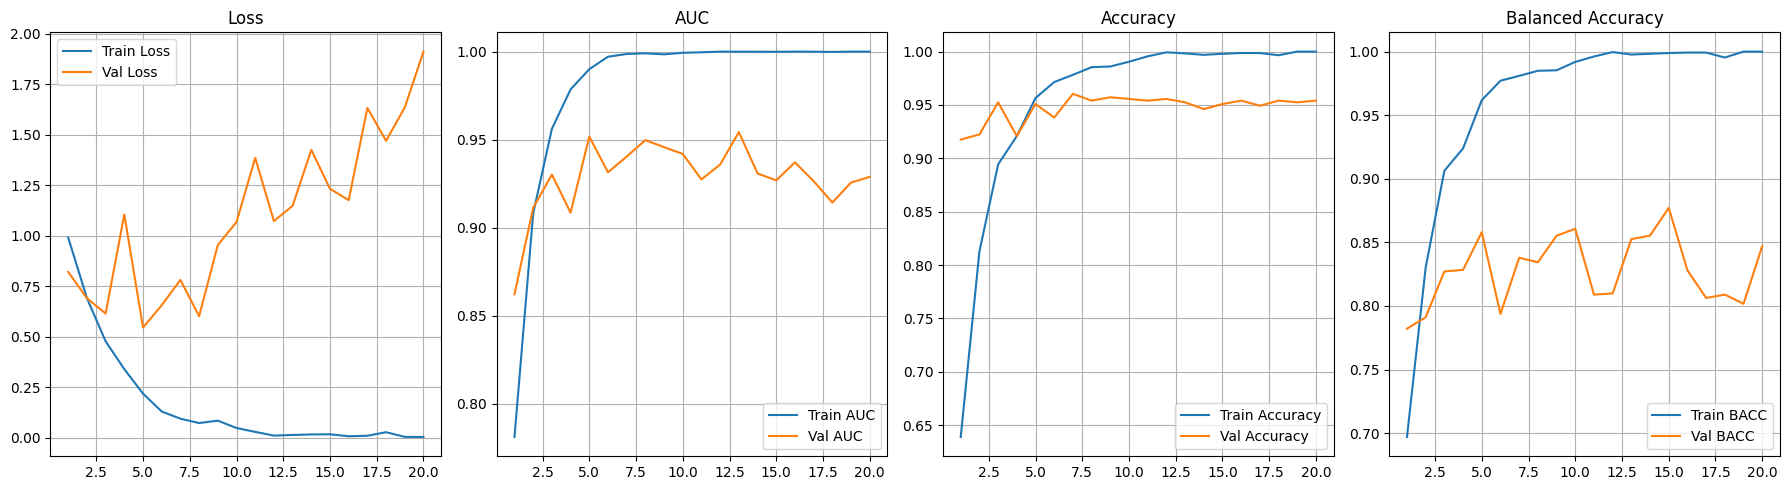


--- Final Test Evaluation ---
Evaluating test set with optimal threshold: 0.46


Test: 100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Test -> Loss: 1.2712 | AUC: 0.9293 | ACC: 0.9287 | BACC: 0.8372 | F1: 0.6853
Prediction Distribution: {np.int64(0): 556, np.int64(1): 75}

Final Test Metrics (Threshold = 0.46):
  -> Accuracy (ACC)         : 0.9287
  -> Balanced Accuracy (BACC): 0.8372
  -> AUC                    : 0.9293
  -> pAUC (FPR<=0.2)        : 0.7719
  -> F1-Score               : 0.6853


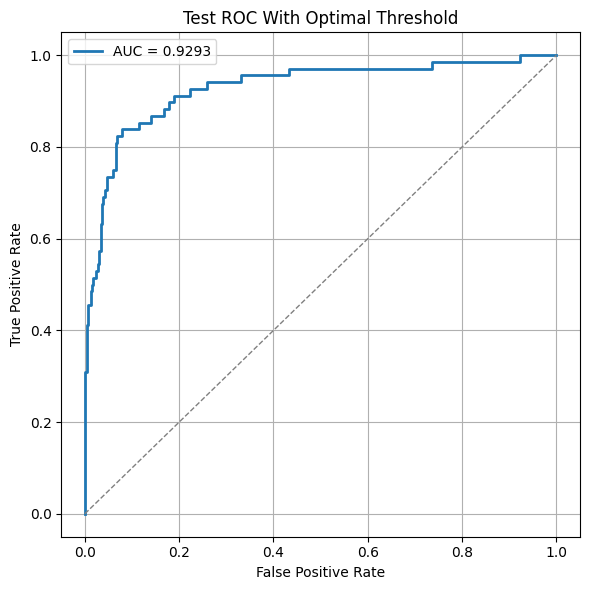

TP: 49 | TN: 537 | FP: 26 | FN: 19 | Precision: 0.6533 | Recall: 0.7206 | Specificity: 0.9538


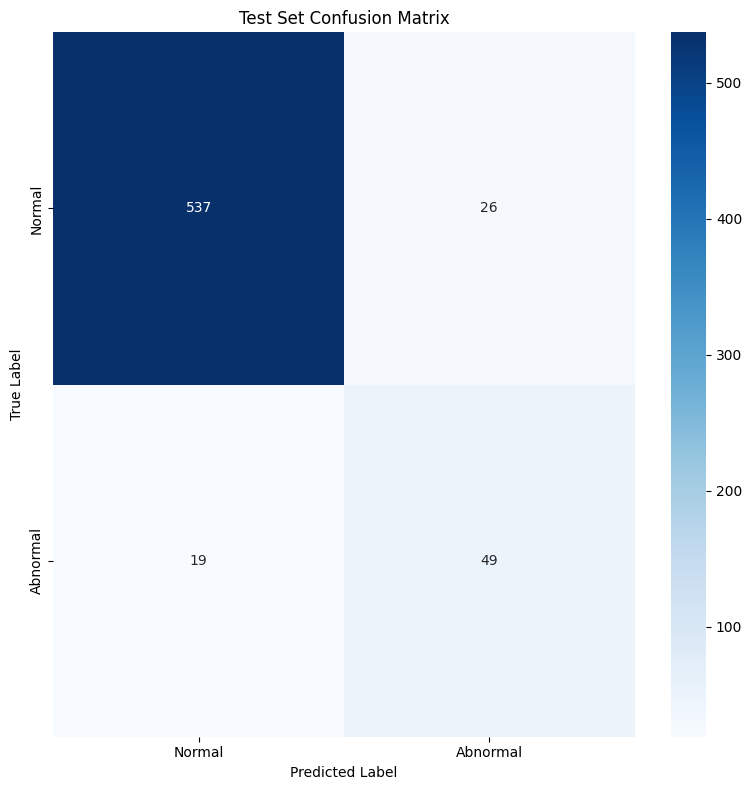

In [6]:
def main():
    # --- Configuration ---
    SEED = 42
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # --- Data Transformations ---
    train_transform = transforms.Compose([
        ZScoreNormalizeSpectrogram(),
        AugmentSpectrogram(time_mask_param=2, freq_mask_param=2) 
    ])
    val_test_transform = transforms.Compose([
        ZScoreNormalizeSpectrogram(),
    ])
    # --- Dataset Loading ---
    print("Loading datasets for CQT spectrograms...")
    full_dataset_aug = PairedSpectrogramDataset(base_dir=FEATURES_DIR, transform=train_transform)
    full_dataset_norm = PairedSpectrogramDataset(base_dir=FEATURES_DIR, transform=val_test_transform)
    all_labels = full_dataset_aug.labels
    
    indices = list(range(len(all_labels)))
    train_idx, temp_idx = train_test_split(indices, test_size=0.3, stratify=all_labels, random_state=SEED)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=[all_labels[i] for i in temp_idx], random_state=SEED)
    
    train_set = Subset(full_dataset_aug, train_idx)
    val_set = Subset(full_dataset_norm, val_idx)
    test_set = Subset(full_dataset_norm, test_idx)

    print(f"Split Sizes => Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")
    print(f"Label Distribution (Train): {Counter([all_labels[i] for i in train_idx])}")
    print(f"Label Distribution (Validation): {Counter([all_labels[i] for i in val_idx])}")
    print(f"Label Distribution (Test): {Counter([all_labels[i] for i in test_idx])}")

    # --- Data Loaders ---
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

    print(f"Data split => Train: {len(train_set)}, Validation: {len(val_set)}, Test: {len(test_set)}")
    print(f"Label Distribution (Train): {Counter([all_labels[i] for i in train_idx])}")

    # --- Model, Criterion, and Optimizer Setup ---
    # ResNet18 (STFT) -> 512, MobileViT-XXS (CQT) -> 320. Total = 832.
    head = AnomalyScorer(in_dim=832, dropout=0.4, mode='classifier-1')
    model = SimpleFusedModel(head=head).to(device)

    # Use weighted Binary Cross-Entropy loss for imbalanced data
    pos_weight = torch.tensor([all_labels.count(0) / all_labels.count(1)], dtype=torch.float32).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    print(f"\nUsing BCEWithLogitsLoss with pos_weight: {pos_weight.item():.2f}")

    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

    model_path = os.path.join(CHECKPOINT_DIR, "best_model.pth")
    os.makedirs(os.path.dirname(model_path), exist_ok=True)

    # --- Training ---
    print("\nStarting model training...")
    best_threshold = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=NUM_EPOCHS,
        model_save_path=model_path,
        device=device,
        save_plots=True,
        patience=PATIENCE
    )
    
    # --- Final Test Evaluation ---
    print("\n--- Final Test Evaluation ---")
    model.load_state_dict(torch.load(model_path, map_location=device))

    # Evaluate using the best threshold found during validation
    print(f"Evaluating test set with optimal threshold: {best_threshold:.2f}")
    
    # The simplified evaluate_model now returns the f1 score directly
    _, test_auc, test_acc, test_bacc, test_f1, all_labels_test, all_probs_test, _ = evaluate_model(
        model=model, data_loader=test_loader, criterion=criterion, phase="Test", device=device, threshold=best_threshold
    )
    
    # We must set the threshold for the test evaluation predictions.
    # The new evaluate_model does not take threshold as an argument, so we apply it manually for the final report.
    all_preds_test = (np.array(all_probs_test) > best_threshold).astype(int)
    final_acc = accuracy_score(all_labels_test, all_preds_test)
    final_bacc = balanced_accuracy_score(all_labels_test, all_preds_test)
    final_f1 = f1_score(all_labels_test, all_preds_test)
    final_pauc = calculate_pAUC(labels=all_labels_test, preds=all_probs_test, max_fpr=0.2)

    print(f"\nFinal Test Metrics (Threshold = {best_threshold:.2f}):")
    print(f"  -> Accuracy (ACC)         : {final_acc:.4f}")
    print(f"  -> Balanced Accuracy (BACC): {final_bacc:.4f}")
    print(f"  -> AUC                    : {test_auc:.4f}")
    print(f"  -> pAUC (FPR<=0.2)        : {final_pauc:.4f}")
    print(f"  -> F1-Score               : {final_f1:.4f}")

    # --- Plotting ---
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true=all_labels_test, y_score=all_probs_test)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, lw=2, label=f"AUC = {test_auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Test ROC With Optimal Threshold")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(CHECKPOINT_DIR, "roc_test_optimal.png"))
    plt.show()
    plt.close()

    class_labels = ["Normal", "Abnormal"]
    plot_confusion_matrix(y_true=all_labels_test, y_pred=all_preds_test, labels=class_labels, save_path=CHECKPOINT_DIR, title="Test Set Confusion Matrix")


if __name__ == "__main__":
    main()